### Import all dependencies

In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

C:\Users\athik\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\athik\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


### Define Few Parameters

In [2]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 10
batch_size = 32

#define paths
covid_path = r"C:\Users\athik\OneDrive\Documents\personal\projects\New folder\COVID"
noncovid_path =  r"C:\Users\athik\OneDrive\Documents\personal\projects\New folder\non-COVID"

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [3]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\COVID\\Covid (1).png', 'C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\COVID\\Covid (10).png', 'C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\COVID\\Covid (100).png', 'C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\COVID\\Covid (101).png', 'C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\COVID\\Covid (102).png']
Total Count:  348
First 5 NonCovid Files:  ['C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\non-COVID\\Non-Covid (1).png', 'C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\non-COVID\\Non-Covid (10).png', 'C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\non-COVID\\Non-Covid (100).png', 'C:\\Users\\athik\\OneDrive\\Documents\\personal\\projects\\New folder\\non-COVID\\Non-Covid (101).png', 'C:\\Users\\athik\\OneDrive\\Docum

### Fetch Images and Class Labels from Files (This might take a while)

In [4]:
import cv2

# Initialize lists to hold labels and images
covid_labels = []
noncovid_labels = []

covid_images = []
noncovid_images = []

# Process COVID images
for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])  # Read the image file
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format
    image = cv2.resize(image, (224, 224))  # Resize the image to 224x224 pixels
    covid_images.append(image)  # Append processed image to the list
    covid_labels.append('CT_COVID')  # Append the corresponding label

# Process Non-COVID images
for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    noncovid_images.append(image)
    noncovid_labels.append('CT_NonCOVID')


### Visualize First 40 Images from Data set

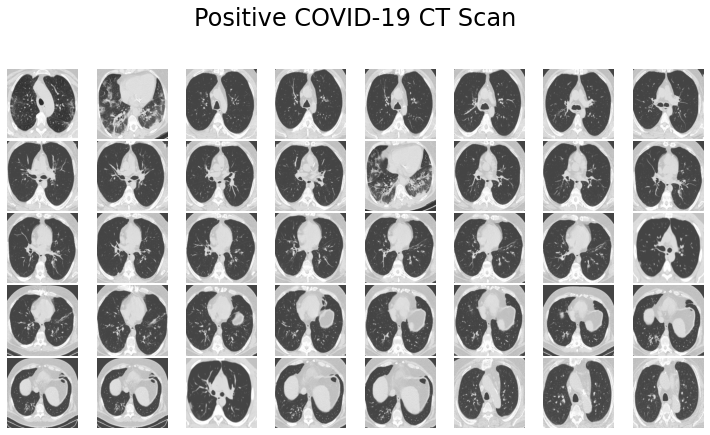

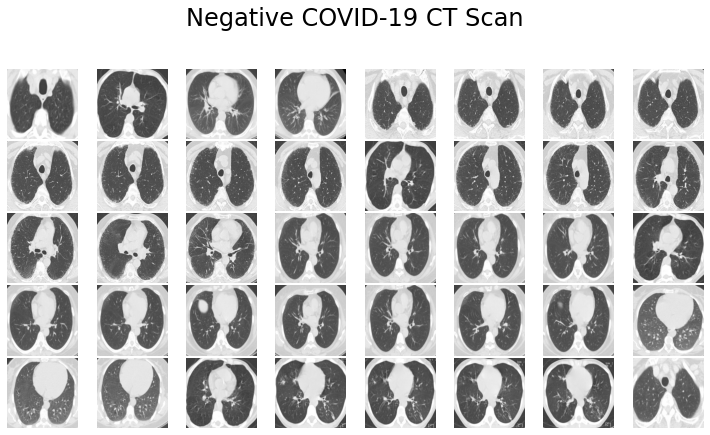

In [5]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [6]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [7]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

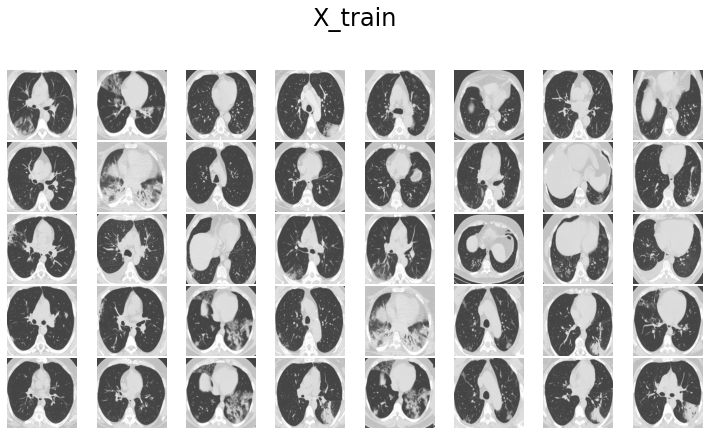

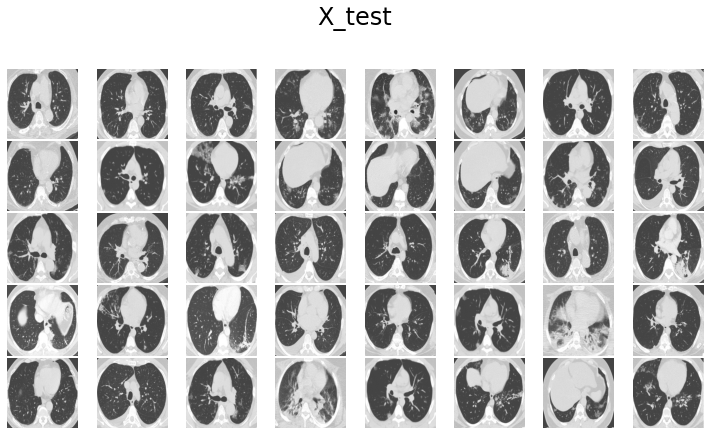

In [8]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [9]:
# Building Model
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [10]:
# Visualize Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [12]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/10


17/17 [==============================] - 73s 4s/step - loss: 0.9917 - accuracy: 0.5586 - val_loss: 0.8068 - val_accuracy: 0.5797
Epoch 2/10
17/17 [==============================] - 68s 4s/step - loss: 0.6236 - accuracy: 0.6722 - val_loss: 0.4043 - val_accuracy: 0.8696
Epoch 3/10
17/17 [==============================] - 68s 4s/step - loss: 0.5424 - accuracy: 0.7546 - val_loss: 0.3450 - val_accuracy: 0.8478
Epoch 4/10
17/17 [==============================] - 67s 4s/step - loss: 0.5040 - accuracy: 0.7766 - val_loss: 0.6120 - val_accuracy: 0.6812
Epoch 5/10
17/17 [==============================] - 67s 4s/step - loss: 0.5060 - accuracy: 0.7894 - val_loss: 0.3740 - val_accuracy: 0.8043
Epoch 6/10
17/17 [==============================] - 67s 4s/step - loss: 0.3535 - accuracy: 0.8535 - val_loss: 0.2030 - val_accuracy: 0.9565
Epoch 7/10
17/17 [==============================] - 66s 4s/step - loss: 0.3143 - accuracy: 0.8736 - val_loss: 0.1962 - val_accuracy: 0.9348
Epoch 8/10
17/17 [

In [13]:
# Save Model and Weights
model.save('vgg_ct.h5')
model.save_weights('vgg_weights_ct.hdf5')

C:\Users\athik\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Load saved model
model = load_model('vgg_ct.h5')

### **Making Predicions**

In [15]:
y_pred = model.predict(X_test, batch_size=batch_size)

5/5 [==============================] - 19s 4s/step


### Visulaizing First 10 predictions

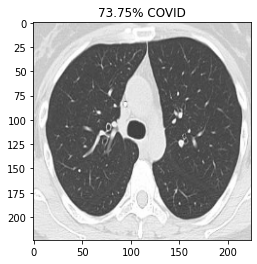

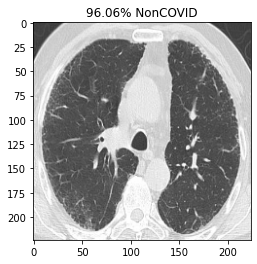

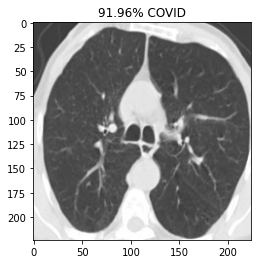

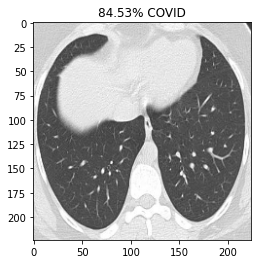

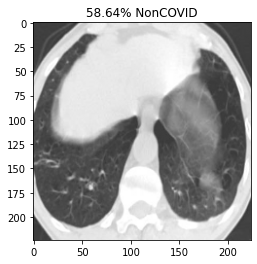

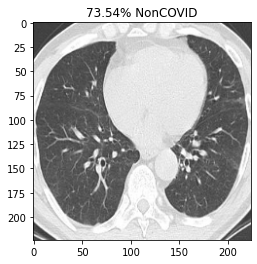

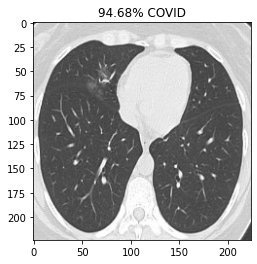

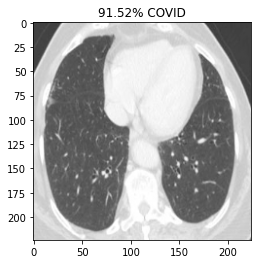

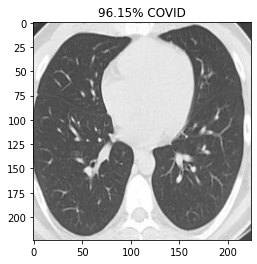

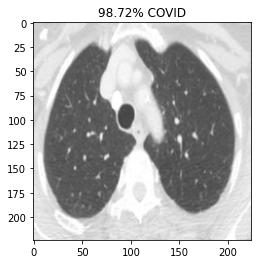

In [16]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
    plt.imshow(X_test[index])
    plt.show()

In [17]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

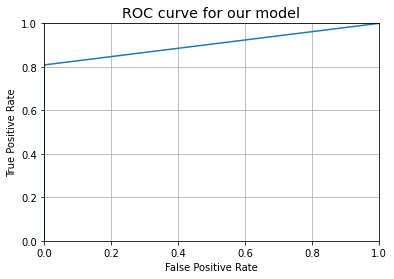

In [18]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


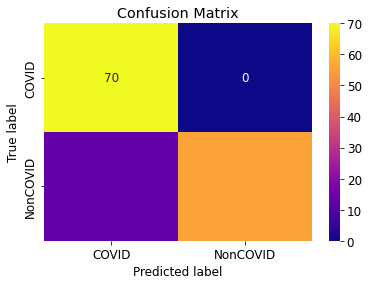

Confusion Matrix with Normalized Values


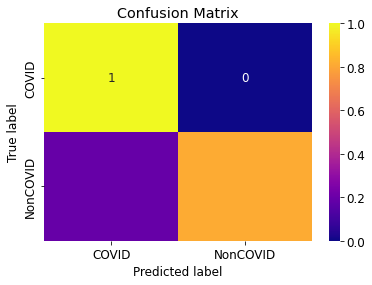

In [23]:
def plot_confusion_matrix(normalize):
    classes = ['COVID','NonCOVID']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92        70
           1       1.00      0.81      0.89        68

    accuracy                           0.91       138
   macro avg       0.92      0.90      0.90       138
weighted avg       0.92      0.91      0.90       138



### **Accuracy and Loss Plots**

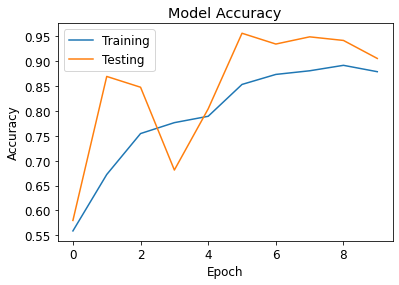

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()


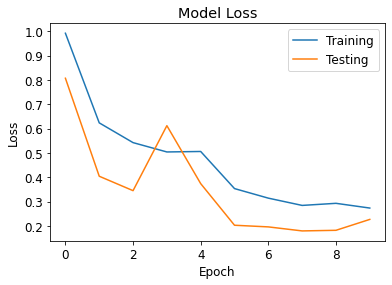

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()